# Statistics 2 - Project - Assignment #2

#### Jeremy (931215248) and Uri (300691367)
---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('ggplot')

In [ ]:
# load data
# file downloaded from
# https://www.kaggle.com/datasets/khairullahhamsafar/hotels-booking-data-cleaned-version
# and dropped as is in the notebook

df = pd.read_csv("hotel_booking_data_cleaned.csv")

### Data preprocessing
Below is the code to create the aforementioned features:

In [ ]:
# 1. sum of all guests in reservation
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# 2. sum of all nights in reservation
df['number_of_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# 3. binary indicator whether a weekend night included in reservation
df['weekend_included'] = df['stays_in_weekend_nights'].map(lambda x: 1 if x > 0 else 0)

# 4. First, concatenate the relevant columns and convert the type to obtain a datetime value.
df['arrival_date'] = df['arrival_date_month'].astype(str) + ' ' + df['arrival_date_day_of_month'].astype(str) + ', ' + df['arrival_date_year'].astype(str)
df['arrival_date'] = df['arrival_date'].apply(lambda x: datetime.strptime(x, "%B %d, %Y"))
# Next, identify day_0 and calculate the new column values based on it.
day_0 = df['arrival_date'].sort_values().values[0]
df['arrival_day'] = df['arrival_date'].map(lambda x: (x - day_0) / np.timedelta64(1, 'D'))

# 5. extract day of the week from the date of arrival
df['arrival_day_of_week'] = df['arrival_date'].map(lambda x: x.strftime('%a'))

# remove rows with 'total_guests' = 0 or 'number_of_nights' = 0 or 'adr' = 0
df = df.loc[(df['total_guests'] > 0) & (df['number_of_nights'] > 0) & (df['adr'] > 0)]

# remove extreme outlier (removing 1 row)
df = df.loc[df['adr'] < 5000] #.reset_index(drop=True)

# 6. create another new column
df['adr_per_guest'] = df['adr'] / df['total_guests']


# narrowing down data

# select only records from top 1 country, and top 1 hotel
df = df.loc[(df['hotel'] == 'City Hotel') & (df['country'] == 'PRT')]

# selecting features
selected_columns = [
    'is_canceled', 'lead_time', 'arrival_date_year',
    'arrival_date_month', 'arrival_day_of_week', 'arrival_day',
    'number_of_nights', 'weekend_included', 'is_repeated_guest',
    'deposit_type', 'adr', 'total_guests', 'adr_per_guest'
    ]
df = df[selected_columns].copy()


# sample 20000 random data points
n = 20000
df = df.sample(n, random_state=27).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_canceled          20000 non-null  int64  
 1   lead_time            20000 non-null  int64  
 2   arrival_date_year    20000 non-null  int64  
 3   arrival_date_month   20000 non-null  object 
 4   arrival_day_of_week  20000 non-null  object 
 5   arrival_day          20000 non-null  float64
 6   number_of_nights     20000 non-null  int64  
 7   weekend_included     20000 non-null  int64  
 8   is_repeated_guest    20000 non-null  int64  
 9   deposit_type         20000 non-null  object 
 10  adr                  20000 non-null  float64
 11  total_guests         20000 non-null  float64
 12  adr_per_guest        20000 non-null  float64
dtypes: float64(4), int64(6), object(3)
memory usage: 2.0+ MB


**QUESTION 1 : Estimations**

1-A)

We will change our question from project 1 to : Do guests who return (i.e., with repeated_guest equals 1) tend to pay a different average nightly rate (i.e., different 'adr')?

Average for each category :



In [ ]:
repeated_guest_df = df[df['is_repeated_guest'] == 1 ]
first_time_guest_df = df[df['is_repeated_guest'] == 0 ]
avg_repeated_guest_all = repeated_guest_df['adr'].mean()
avg_first_time_guest_all = first_time_guest_df['adr'].mean()
print("Average nightly rate for a returning guest: {}".format(avg_repeated_guest_all))
print("Average nightly rate for a first time guest: {}".format(avg_first_time_guest_all))


Average nightly rate for a returning guest: 76.61230021598271
Average nightly rate for a first time guest: 95.72237233931004


The average is the maximum likelihood estimator of esperancy. As we already know, the maximum likelihood estimator respects the asymptotic normality property.
Interval Confidences of esperancy for each category :

1-B) Confidence intervals for average nightly rate for each category

In [ ]:
n_repeated_guest = len(repeated_guest_df['adr'])
n_first_time_guest = len(first_time_guest_df['adr'])
sample_var_repeated = repeated_guest_df['adr'].var(ddof=0)
sample_var_first = first_time_guest_df['adr'].var(ddof=0)
se_repeated = ((1/n_repeated_guest)*sample_var_repeated)**(1/2)
se_first = ((1/n_first_time_guest)*sample_var_first)**(1/2)
conf_interval_repeated = [avg_repeated_guest_all - 2*se_repeated, avg_repeated_guest_all + 2*se_repeated]
conf_interval_first = [avg_first_time_guest_all - 2*se_first, avg_first_time_guest_all + 2*se_first]

print("Confidence interval for average nightly rate among first time guests: {}".format(conf_interval_first))
print("Confidence interval for average nightly rate among returning guests: {}".format(conf_interval_repeated))

Confidence interval for average nightly rate among first time guests: [95.23424328987738, 96.2105013887427]
Confidence interval for average nightly rate among returning guests: [75.06123257041652, 78.1633678615489]


1-C) What can we say from these two confidence intervals ?

The two confidence intervals do not intersect each other. We can interpret this result as that the two categories are well seperated. That means we can expect the statistic significance to be high.

**QUESTION 2 : Statistical Hypothesis Test**

2-A) Hypothesis 0 and the alternative hypothesis

H0 : mu_first_time - mu_repeated = 0

H1 : mu_first_time - mu_repeated != 0

where mu_first_time is the average nightly rate esperancy among first time guests and mu_repeated is the average nightly rate esperancy among repeated guests.

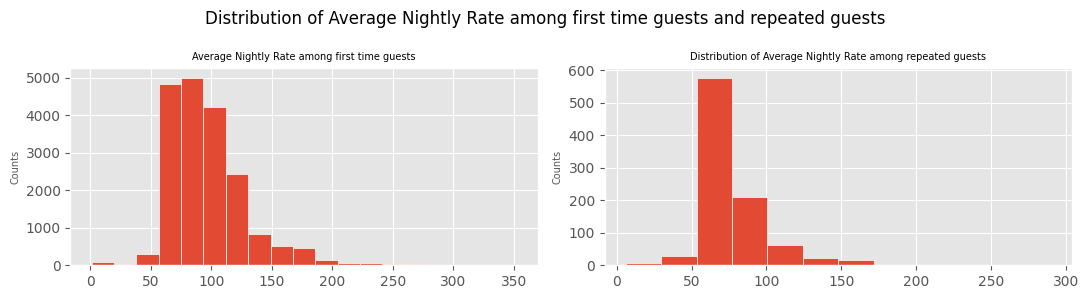

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11,3))
fig.suptitle('Distribution of Average Nightly Rate among first time guests and repeated guests')

ax[0].hist(first_time_guest_df['adr'], edgecolor = "white", bins=19)
ax[0].set_ylabel("Counts", fontsize=7)
ax[0].set_title('Average Nightly Rate among first time guests', fontsize=7)

ax[1].hist(repeated_guest_df['adr'], edgecolor = "white", bins=12)
ax[1].set_ylabel("Counts", fontsize=7)
ax[1].set_title('Distribution of Average Nightly Rate among repeated guests', fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
print("Variance of first time guests sample : {}".format(sample_var_first))
print("Variance of repeated guests sample : {}".format(sample_var_repeated))

Variance of first time guests sample : 1136.1903466997824
Variance of repeated guests sample : 556.9452097198057


2-B) Are the variances equal ?

In [ ]:
# Calculating the F statistic to check variance equality
import numpy as np
import scipy.stats as stats
F_statistic = first_time_guest_df['adr'].var()/repeated_guest_df['adr'].var()
p_value = 1-stats.f.cdf(F_statistic,n_first_time_guest-1, n_repeated_guest-1)
F_test_quantile = stats.f.ppf(0.95, n_first_time_guest-1, n_repeated_guest-1)
print("F statistic: {}".format(F_statistic))
print("P value: {}".format(p_value))
print("F test quantile: {}".format(F_test_quantile))
print("Is it in Reject Region? {}".format(F_statistic > F_test_quantile))

F statistic: 2.037943492035058
P value: 1.1102230246251565e-16
F test quantile: 1.0832503279747474
Is it in Reject Region? True


We can infer from the test F that the variances are not equal. From this result, we can consider that not all the assumptions for T test are respected.

2-C) The T-Test

In [ ]:
# Performing T test
T_statistic, T_P_value = stats.ttest_ind(first_time_guest_df['adr'], repeated_guest_df['adr'], equal_var=True)
T_test_quantile = stats.t.ppf(0.975, n_first_time_guest+n_repeated_guest-2)
print("T statistic: {}".format(T_statistic))
print("P value: {}".format(T_P_value))
print("T test quantile: {}".format(T_test_quantile))
print("In Reject Region: {}".format(T_test_quantile < abs(T_statistic)))

T statistic: 17.049574010169753
P value: 1.009603716200391e-64
T test quantile: 1.9600826170220886
In Reject Region: True


2-D) The Wald Test

In [ ]:
# Performing Wald test
import statsmodels.api as sm

Wald_statistic = (avg_first_time_guest_all - avg_repeated_guest_all)/((sample_var_first/n_first_time_guest + sample_var_repeated/n_repeated_guest)**1/2)
P_value = 2*stats.norm.cdf(-abs(Wald_statistic))
W_test_quantile = stats.norm.ppf(0.975)
print("Wald statistic: {}".format(Wald_statistic))
print("P value: {}".format(P_value))
print("W test quantile: {}".format(W_test_quantile))
print("In Reject Region: {}".format(W_test_quantile < abs(Wald_statistic)))

Wald statistic: 57.81993364466396
P value: 0.0
W test quantile: 1.959963984540054
In Reject Region: True


2-E) We get two different P values from the T and the Wald Test. But we can consider the P value from the T test very close to 0. So we can infer that the two results very close to each other.

2-F) Maximum Likelihood Ratio Test

In [ ]:
import math

def build_sum_element(values, n_category, S_p_squared, variance_estimate,mu_estimate_category,mu_estimate_all):
  sum = 0
  for i in range(n_category):
    sum += (values[i]-mu_estimate_all)**2/variance_estimate - (values[i]-mu_estimate_category)**2/S_p_squared

  return sum

S_p_squared = ((n_first_time_guest-1)*sample_var_first+(n_repeated_guest-1)*sample_var_repeated)/(n_first_time_guest+n_repeated_guest-2)
first_values = first_time_guest_df["adr"].values
repeated_values = repeated_guest_df["adr"].values
sample_variance = df["adr"].var(ddof = 0)
avg_all = df["adr"].mean()
n = n_first_time_guest + n_repeated_guest

first_elem = n*math.log(sample_variance/S_p_squared)

first_time_elem = build_sum_element(first_values, n_first_time_guest, S_p_squared, sample_variance, avg_first_time_guest_all,avg_all)
repeated_elem = build_sum_element(repeated_values, n_repeated_guest, S_p_squared, sample_variance, avg_repeated_guest_all,avg_all)

statistic = first_elem + first_time_elem + repeated_elem
test_quantile = stats.chi2.ppf(0.95,1)

print(f"The statistic is: {statistic}")
print(f"The test quantile is: {test_quantile}")
print(f"Do we reject H0 ? Answer: {statistic > test_quantile}")



The statistic is: 288.62438464829916
The test quantile is: 3.841458820694124
Do we reject H0 ? Answer: True


**QUESTION 3 : Different Sample Size**

3-A) Choosing some samples with different sizes

We noticed that the dataset contains way more tuples with 'is_repeated_guest' value of 0 (approximatly 20 times more). In order to have balanced samples, we sample half of the sample size tuples with 'is_repeated_guest' equals 0 and the other half with 'is_repeated_guest' equals 1.


In [ ]:
# choosing different sample size

size = [30, 50, 100, 500]

# choosing size = 30
df_30_rep = repeated_guest_df.sample(int((size[0]/2)), random_state = 1, replace = True).reset_index(drop=True)
df_30_first = first_time_guest_df.sample(int(size[0]/2), random_state = 1, replace = True).reset_index(drop=True)
df_30 = pd.concat([df_30_rep, df_30_first])
df_30.reset_index(drop=True, inplace=True)

# choosing size = 50
df_50_rep = repeated_guest_df.sample(int((size[1]/2)), random_state = 2, replace = True).reset_index(drop=True)
df_50_first = first_time_guest_df.sample(int(size[1]/2), random_state = 2, replace = True).reset_index(drop=True)
df_50 = pd.concat([df_50_rep, df_50_first])
df_50.reset_index(drop=True, inplace=True)

# choosing size = 100
df_100_rep = repeated_guest_df.sample(int((size[2]/2)), random_state = 3, replace = True).reset_index(drop=True)
df_100_first = first_time_guest_df.sample(int(size[2]/2),random_state = 3,  replace = True).reset_index(drop=True)
df_100 = pd.concat([df_100_rep, df_100_first])
df_100.reset_index(drop=True, inplace=True)

# choosing size = 500
df_500_rep = repeated_guest_df.sample(int((size[3]/2)), random_state = 4, replace = True).reset_index(drop=True)
df_500_first = first_time_guest_df.sample(int(size[3]/2), random_state = 4, replace = True).reset_index(drop=True)
df_500 = pd.concat([df_500_rep, df_500_first])
df_500.reset_index(drop=True, inplace=True)

dfs = [df_30, df_50, df_100, df_500]


3-B-C) Confidence intervals for average nightly rate and Wald Test for each category for each sample

In [ ]:
size = [30, 50, 100, 500]
for i in range(4):
  curr_repeated_guest_df = dfs[i][dfs[i]['is_repeated_guest'] == 1 ]
  curr_first_time_guest_df = dfs[i][dfs[i]['is_repeated_guest'] == 0 ]
  curr_avg_repeated_guest = curr_repeated_guest_df['adr'].mean()
  curr_avg_first_time_guest = curr_first_time_guest_df['adr'].mean()

  n_repeated_guest = int(size[i]/2)
  n_first_time_guest = int(size[i]/2)

  curr_sample_var_repeated = curr_repeated_guest_df['adr'].var(ddof=0)
  curr_sample_var_first = curr_first_time_guest_df['adr'].var(ddof=0)

  curr_se_repeated = ((1/n_repeated_guest)*curr_sample_var_repeated)**(1/2)
  curr_se_first = ((1/n_first_time_guest)*sample_var_first)**(1/2)

  curr_Wald_statistic = (curr_avg_first_time_guest - curr_avg_repeated_guest)/((curr_sample_var_first/n_first_time_guest + curr_sample_var_repeated/n_repeated_guest)**1/2)
  curr_P_value = 2*stats.norm.cdf(-abs(curr_Wald_statistic))
  curr_W_test_quantile = stats.norm.ppf(0.975)

  curr_conf_interval_repeated = [curr_avg_repeated_guest - 2*curr_se_repeated, curr_avg_repeated_guest + 2*curr_se_repeated]
  curr_conf_interval_first = [curr_avg_first_time_guest - 2*curr_se_first, curr_avg_first_time_guest + 2*curr_se_first]

  print("Sample of size : {}".format(size[i]))
  print()
  print("Confidence interval for average nightly rate among first time guests in sample of size {} : {}".format(size[i], curr_conf_interval_first))
  print("Confidence interval for average nightly rate among returning guests in sample of size {} : {}".format(size[i], curr_conf_interval_repeated))
  print()
  print("Wald statistic: {}".format(curr_Wald_statistic))
  print("P value: {}".format(curr_P_value))
  print("W test quantile: {}".format(curr_W_test_quantile))
  print("In Reject Region: {}".format(curr_W_test_quantile < abs(curr_Wald_statistic)))
  print()
  print()

Sample of size : 30

Confidence interval for average nightly rate among first time guests in sample of size 30 : [79.88556175280894, 114.69843824719104]
Confidence interval for average nightly rate among returning guests in sample of size 30 : [63.25225104498855, 81.38774895501143]

Wald statistic: 0.5277467788393428
P value: 0.5976751007469521
W test quantile: 1.959963984540054
In Reject Region: False


Sample of size : 50

Confidence interval for average nightly rate among first time guests in sample of size 50 : [78.33383091036825, 105.29976908963175]
Confidence interval for average nightly rate among returning guests in sample of size 50 : [68.38545806534896, 87.86494193465103]

Wald statistic: 0.39050363280515554
P value: 0.6961641695341767
W test quantile: 1.959963984540054
In Reject Region: False


Sample of size : 100

Confidence interval for average nightly rate among first time guests in sample of size 100 : [86.52250112619278, 105.59029887380721]
Confidence interval for aver

Comparing these confidence intervals with those in question 1, we can notice that the more the sample's size grows, the more the confidence intervals's length decreases. The confidence intervals's length from question 1 are smaller than the confidence intervals's length in this section.

The Wald test in question 2 led to the alternative hypothesis. Here, we have less data than the whole dataset. Because of the lack of data quantity, we could not choose to reject H0. That's why we did not reject H0 with samples of size 30, 50 and 100. We can infer that with a sample of size 500, we had enough data to reject H0 with a significance level of 0.05.

3-D) Repeating 100 times

In [ ]:
size = [30, 50, 100, 500]

interval_30_first = []
interval_30_repeated = []
interval_50_first = []
interval_50_repeated = []
interval_100_first = []
interval_100_repeated = []
interval_500_first = []
interval_500_repeated = []

p_values_30 = []
p_values_50 = []
p_values_100 = []
p_values_500 = []

interval_repeated_count_30 = 0
interval_repeated_count_50 = 0
interval_repeated_count_100 = 0
interval_repeated_count_500 = 0
interval_repeated_count = [interval_repeated_count_30, interval_repeated_count_50, interval_repeated_count_100, interval_repeated_count_500]

interval_first_count_30 = 0
interval_first_count_50 = 0
interval_first_count_100 = 0
interval_first_count_500 = 0
interval_first_count = [interval_first_count_30, interval_first_count_50, interval_first_count_100, interval_first_count_500]

p_values_count_30 = 0
p_values_count_50 = 0
p_values_count_100 = 0
p_values_count_500 = 0
p_values_count = [p_values_count_30, p_values_count_50, p_values_count_100, p_values_count_500]

interval_first = [interval_30_first, interval_50_first, interval_100_first, interval_500_first]
interval_repeated = [interval_30_repeated, interval_50_repeated, interval_100_repeated, interval_500_repeated]

p_values = [p_values_30, p_values_50, p_values_100, p_values_500]

for i in range(100):

  # choosing size = 30
  df_30_rep = repeated_guest_df.sample(int((size[0]/2)), random_state = i, replace = True).reset_index(drop=True)
  df_30_first = first_time_guest_df.sample(int(size[0]/2), random_state = i, replace = True).reset_index(drop=True)
  df_30 = pd.concat([df_30_rep, df_30_first])
  df_30.reset_index(drop=True, inplace=True)

  # choosing size = 50
  df_50_rep = repeated_guest_df.sample(int((size[1]/2)), random_state = (i + 100), replace = True).reset_index(drop=True)
  df_50_first = first_time_guest_df.sample(int(size[1]/2), random_state = (i + 100), replace = True).reset_index(drop=True)
  df_50 = pd.concat([df_50_rep, df_50_first])
  df_50.reset_index(drop=True, inplace=True)

  # choosing size = 100
  df_100_rep = repeated_guest_df.sample(int((size[2]/2)), random_state = (i + 200), replace = True).reset_index(drop=True)
  df_100_first = first_time_guest_df.sample(int(size[2]/2),random_state = (i + 200),  replace = True).reset_index(drop=True)
  df_100 = pd.concat([df_100_rep, df_100_first])
  df_100.reset_index(drop=True, inplace=True)

  # choosing size = 500
  df_500_rep = repeated_guest_df.sample(int((size[3]/2)), random_state = (i + 300), replace = True).reset_index(drop=True)
  df_500_first = first_time_guest_df.sample(int(size[3]/2), random_state = (i + 300), replace = True).reset_index(drop=True)
  df_500 = pd.concat([df_500_rep, df_500_first])
  df_500.reset_index(drop=True, inplace=True)


  dfs = [df_30, df_50, df_100, df_500]

  for i in range(4):
    curr_repeated_guest_df = dfs[i][dfs[i]['is_repeated_guest'] == 1 ]
    curr_first_time_guest_df = dfs[i][dfs[i]['is_repeated_guest'] == 0 ]
    avg_repeated_guest = curr_repeated_guest_df['adr'].mean()
    avg_first_time_guest = curr_first_time_guest_df['adr'].mean()

    n_repeated_guest = int(size[i]/2)
    n_first_time_guest = int(size[i]/2)

    sample_var_repeated = curr_repeated_guest_df['adr'].var(ddof=0)
    sample_var_first = curr_first_time_guest_df['adr'].var(ddof=0)

    se_repeated = ((1/n_repeated_guest)*sample_var_repeated)**(1/2)
    se_first = ((1/n_first_time_guest)*sample_var_first)**(1/2)

    Wald_statistic = (avg_first_time_guest - avg_repeated_guest)/((sample_var_first/n_first_time_guest + sample_var_repeated/n_repeated_guest)**1/2)
    P_value = 2*stats.norm.cdf(-abs(Wald_statistic))

    conf_interval_repeated = [avg_repeated_guest - 2*se_repeated, avg_repeated_guest + 2*se_repeated]
    conf_interval_first = [avg_first_time_guest - 2*se_first, avg_first_time_guest + 2*se_first]

    p_values[i].append(P_value)
    interval_first[i].append((avg_repeated_guest + 2*se_repeated)-(avg_repeated_guest - 2*se_repeated))
    interval_repeated[i].append((avg_first_time_guest + 2*se_first)-(avg_first_time_guest - 2*se_first))


    if (avg_first_time_guest_all <=  avg_first_time_guest + 2*se_first) and (avg_first_time_guest_all >= avg_repeated_guest - 2*se_repeated):
      interval_first_count[i]+=1

    if (avg_repeated_guest_all <=  avg_repeated_guest + 2*se_repeated) and (avg_repeated_guest_all >= avg_repeated_guest - 2*se_repeated):
      interval_repeated_count[i]+=1



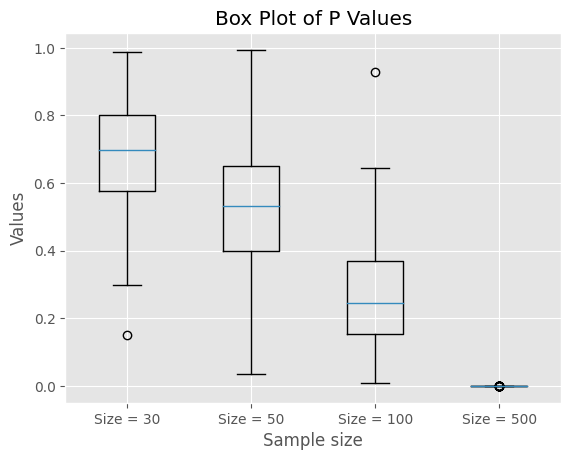

In [ ]:
plt.boxplot(p_values)

# Ajout de titre et d'étiquettes d'axe
plt.title('Box Plot of P Values')
plt.xticks([1, 2, 3, 4], ['Size = 30', 'Size = 50', 'Size = 100', 'Size = 500'])
plt.xlabel('Sample size')
plt.ylabel('Values')

# Affichage du graphique
plt.show()

We decided to represent the distribution of P values as a function of sample sizes as box plots. We can notice that the more we add data, the more p values move closer to 0. The meaning behind this behavior is that we can decide to reject H0 for almost all level of confidence as the number of data grows and the p value gets closer to 0.

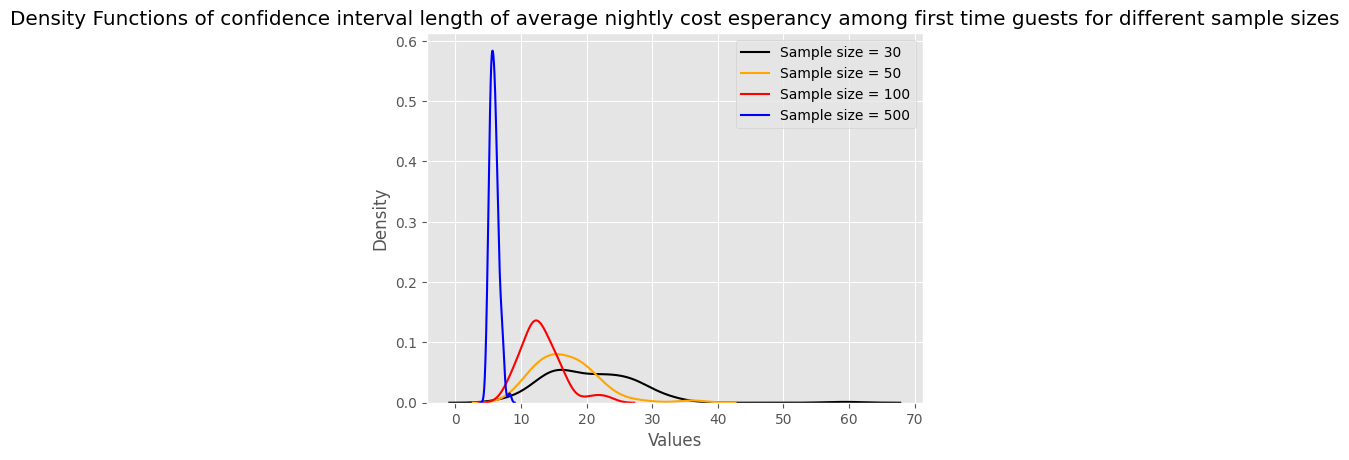

In [ ]:
import seaborn as sns

sns.kdeplot(interval_first[0], fill=False, color='black', label="Sample size = 30")
sns.kdeplot(interval_first[1], fill=False, color='orange', label="Sample size = 50")
sns.kdeplot(interval_first[2], fill=False, color='red', label="Sample size = 100")
sns.kdeplot(interval_first[3], fill=False, color='blue', label="Sample size = 500")
plt.legend()
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Functions of confidence interval length of average nightly cost esperancy among first time guests for different sample sizes')
plt.show()

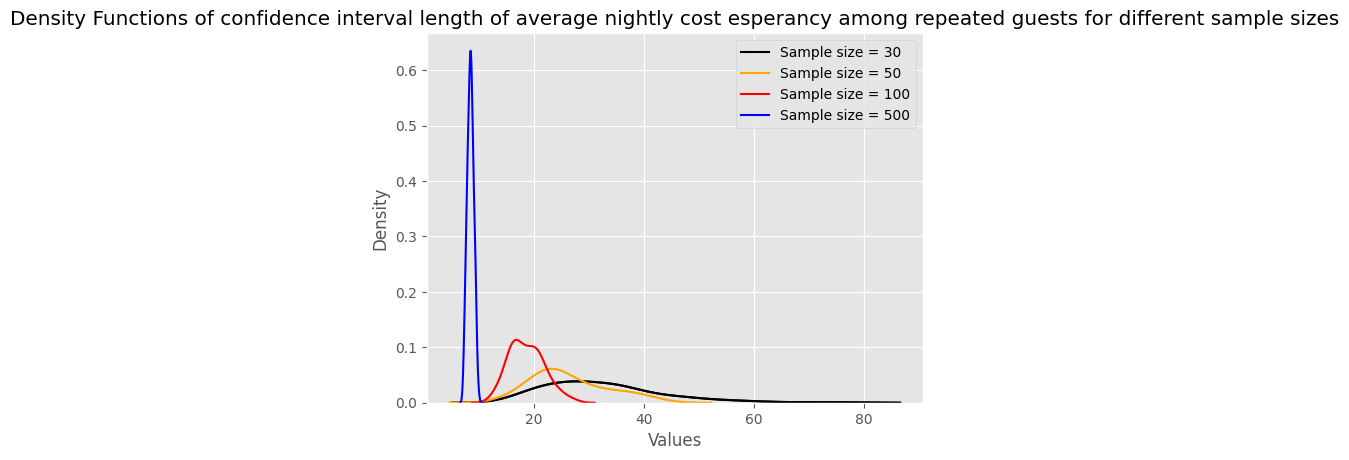

In [ ]:
sns.kdeplot(interval_repeated[0], fill=False, color='black')
sns.kdeplot(interval_repeated[0], fill=False, color='black', label="Sample size = 30")
sns.kdeplot(interval_repeated[1], fill=False, color='orange', label="Sample size = 50")
sns.kdeplot(interval_repeated[2], fill=False, color='red', label="Sample size = 100")
sns.kdeplot(interval_repeated[3], fill=False, color='blue', label="Sample size = 500")
plt.legend()
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Density Functions of confidence interval length of average nightly cost esperancy among repeated guests for different sample sizes')
plt.show()

We decided to represent the condifence intervals length by density functions of the sample size. So that, we can clearly identify on the same grid how the length behaves as a function of the number of data we have. The more data we have, the more the interval's confidence length comes closer to 0 and the variance decreases.

In [ ]:
print("Among first time guests :")
for i in range(4):
  print("In {}%, the real average value of the average nightly rate is included in the confidence interval of sample size {}.".format(interval_first_count[i], size[i]))

Among first time guests :
In 89%, the real average value of the average nightly rate is included in the confidence interval of sample size 30.
In 93%, the real average value of the average nightly rate is included in the confidence interval of sample size 50.
In 94%, the real average value of the average nightly rate is included in the confidence interval of sample size 100.
In 96%, the real average value of the average nightly rate is included in the confidence interval of sample size 500.


In [ ]:
print("Among repeated guests :")
for i in range(4):
  print("In {}%, the real average value of the average nightly rate is included in the confidence interval of sample size {}.".format(interval_repeated_count[i], size[i]))

Among repeated guests :
In 92%, the real average value of the average nightly rate is included in the confidence interval of sample size 30.
In 92%, the real average value of the average nightly rate is included in the confidence interval of sample size 50.
In 92%, the real average value of the average nightly rate is included in the confidence interval of sample size 100.
In 97%, the real average value of the average nightly rate is included in the confidence interval of sample size 500.


In [21]:
!jupyter nbconvert --to html ProjectEx2_931215248_300691367.ipynb

[NbConvertApp] Converting notebook ProjectEx2_931215248_300691367.ipynb to html
[NbConvertApp] Writing 908685 bytes to ProjectEx2_931215248_300691367.html
